In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torchvision
from torch import optim, cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader ,sampler
import matplotlib.pyplot as plt
import os
import time
import cv2
import copy
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'tensorboard'

In [4]:
'''
functions in datahandler 
def process_image(image_path):
def imshow_tensor(image, ax=None, title=None):
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):
def display_prediction(image_path, model, topk):
def predict(image_path, model, topk=5):
def save_checkpoint(model, path,optimizer,history):

make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in datahandler \ndef process_image(image_path):\ndef imshow_tensor(image, ax=None, title=None):\ndef train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):\ndef display_prediction(image_path, model, topk):\ndef predict(image_path, model, topk=5):\ndef save_checkpoint(model, path,optimizer,history):\n\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [5]:
'''
functions in getmethod files  
    def get_pretrained_model(model_name):
    def evaluate(model, test_loader, criterion, topk=[1]):
    def imshow(image):

make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in getmethod files  \n    def get_pretrained_model(model_name):\n    def evaluate(model, test_loader, criterion, topk=[1]):\n    def imshow(image):\n\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu=True

In [7]:
src='C:\\Users\\Harshit\\Desktop\\MTP\\training_folder'
traindir = os.path.join(src,'train')
validdir = os.path.join(src,'val')
testdir = os.path.join(src,'test')
save_file_name = 'densenet121-transfer-4.pt'
checkpoint_path = 'densenet121-transfer-4.pth'
# Change to fit hardware
batch_size = 32
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
cat_df=pd.read_csv('cat_df')

Train on gpu: True
1 gpus detected.


In [8]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [9]:
%run datahandler
%run get_method

1 gpus detected.
1 gpus detected.
1 gpus detected.


In [10]:
batch_size=32
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data = {
    'train':
    datasets.ImageFolder(root=os.path.join(src,'train'), transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=os.path.join(src,'val'), transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [11]:
# Iterate through the dataloader once
trainiter=iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# training

In [12]:
model=models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier.in_features
model.classifier=nn.Linear(num_ftrs,2)
model=model.cuda()

In [13]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Negative'), (1, 'Positive')]

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters())
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

7,085,314 total parameters.
131,458 training parameters.


In [ ]:
save_file_name = 'densenet121-transfer-4.pt'
checkpoint_path = 'densenet121-transfer-4.pth'
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=2,
    print_every=2)

In [ ]:
save_checkpoint(model, checkpoint_path,history)

# loading saved model

In [12]:
model,optimizer,history=load_checkpoint(checkpoint_path)

6,955,906 total parameters.
2,050 total gradient parameters.


# training analysis

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

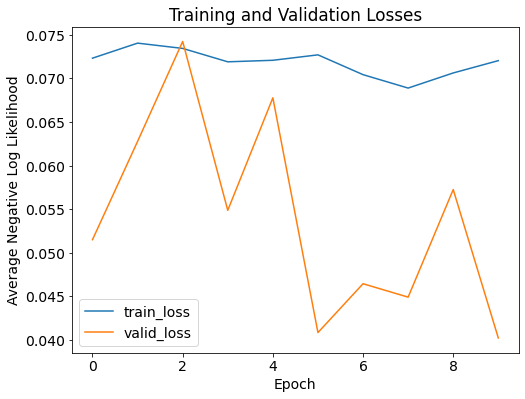

In [13]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

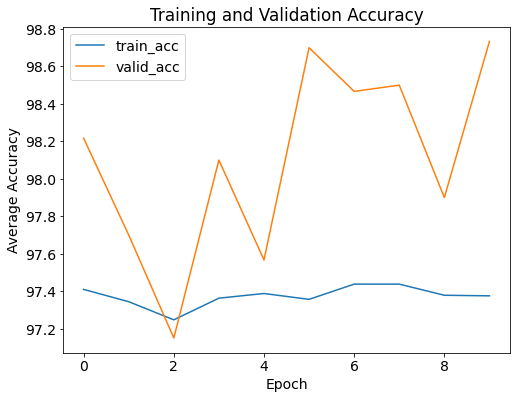

In [14]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


# inference

# prediction

In [15]:
cat_df=pd.read_csv('cat_df')

In [20]:
testdir

'C:\\Users\\Harshit\\Desktop\\MTP\\training_folder\\test'

torch.Size([3, 224, 224])

Positive
[3.970555e+02 7.877530e-03]


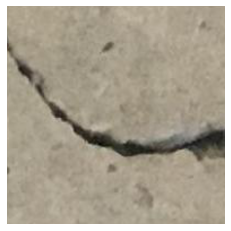

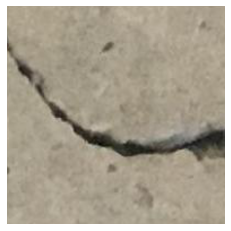

In [18]:
np.random.seed = 100
%matplotlib inline
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = os.path.join(testdir,c)
    img_path = os.path.join(root,np.random.choice(os.listdir(root)))
    return img_path

p=random_test_image()
_ = imshow_tensor(process_image(p))
img, top_p, top_classes, real_class = predict(p, model)
img.shape
ax,image=imshow_tensor(img)
print(real_class)
print(top_p)
plt.imshow(image)



In [34]:
model.class_to_idx[real_class]==np.argmax(top_p,dim=1)

TypeError: _argmax_dispatcher() got an unexpected keyword argument 'dim'

In [50]:
top_p.reshape(2)

NameError: name 'top_top_p' is not defined

torch.Size([3, 224, 224])

Negative
[1.4783180e+02 1.5820056e-02]


0

AxisError: axis 1 is out of bounds for array of dimension 1

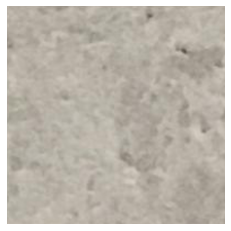

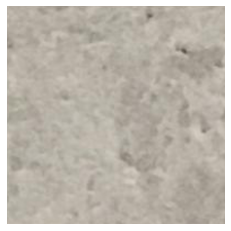

In [40]:
    p=random_test_image()
    _ = imshow_tensor(process_image(p))
    img, top_p, top_classes, real_class = predict(p, model)
    img.shape
    ax,image=imshow_tensor(img)
    print(real_class)
    print(top_p)
    model.class_to_idx[real_class]
    np.argmax(top_p,axis=1)
    plt.imshow(image)



torch.Size([3, 224, 224])

Negative
[5.4327232e+01 3.5894703e-02]


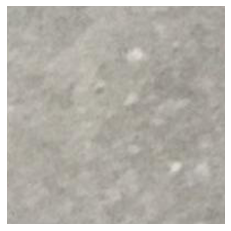

In [22]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape
ax,image=imshow_tensor(img)
print(real_class)
print(top_p)
plt.imshow(image)


In [20]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets,topk=[1])
else:
    accuracy(model(features), targets,topk=[1])


[100.0]

In [113]:
criterion = nn.CrossEntropyLoss()
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,loss
0,Negative,99.9,0.008316
1,Positive,97.6,0.075083


In [30]:
criterion = nn.CrossEntropyLoss()
test_loader=dataloaders['test']
topk=[2]

In [ ]:
acc_results.shape

In [ ]:

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
losses

[0.0003813969960901886,
 0.04461408033967018,
 0.0013016331940889359,
 0.0011606630869209766,
 0.000503770774230361,
 0.0002575780963525176,
 0.0008953376673161983,
 7.64102369430475e-05,
 0.3881392478942871,
 0.003942337818443775,
 2.8371408916427754e-05,
 1.306950330734253,
 0.0002698534226510674,
 0.006835055537521839,
 0.08173251152038574,
 0.0003104920033365488,
 4.8397800128441304e-05,
 0.0004990047891624272,
 0.00010263393050990999,
 0.0008764001540839672,
 0.0009211826254613698,
 0.0002470903273206204,
 0.003909208811819553,
 0.020417282357811928,
 0.016397131606936455,
 0.0008543655276298523,
 0.0002325502864550799,
 9.023735765367746e-05,
 1.2397689715726301e-05,
 0.00021884430316276848,
 0.0007284610182978213,
 0.000388665939681232,
 0.08680222928524017,
 0.00014625910262111574,
 0.004772225394845009,
 0.037101779133081436,
 0.00012492353562265635,
 0.00013255194062367082,
 4.768370445162873e-07,
 0.0007962394156493247,
 0.0013731822837144136,
 0.001210433547385037,
 0.00126

# test results

In [52]:
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)


tensor([[999.,   1.],
        [ 24., 976.]])


In [1]:
TP=976
TN=999
FN=24
FP=1
recall=TP/(TP+FN)
precision=TP/(TP+FP)
f1_score=2*recall*precision/(precision+recall)
acc=(TP+TN)/(TP+TN+FN+FP)

In [2]:
f1_score,acc

(0.9873545776428932, 0.9875)

In [53]:
a=pd.DataFrame(confusion_matrix)

Text(0.5, 6.800000000000011, 'images')

Text(-5.949999999999996, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Top 1 Accuracy vs Number of Training Images')

(-5.0, 105.0)

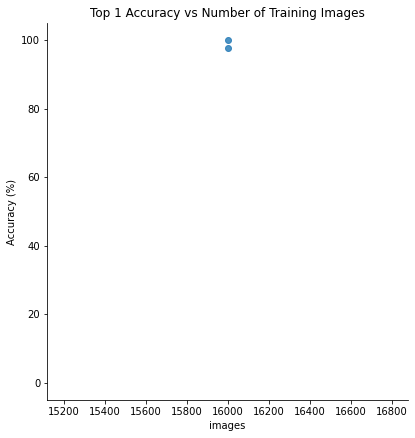

In [115]:
results = results.merge(cat_df, left_on='class', right_on='category').\
drop(columns=['category'])
# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)
